# Contents

Overall, I will have two stages of modelling to conduct my analysis:

- STAGE 1: Predict diagnosis based on MRI features, using a scaler, feature selection and a classifier.
- STAGE 2: Predict age based on the predicted diagnosis from stage 1 and MRI features using a scaler, feature selection and regressor.

I plan to split my data according to this, so I will have 5 groups:
- Training and validation sets for stage 1
- Training and validation sets for stage 2
- Test set

1. Load Data
2. Split data into train, val and test
3. Find the best classifier model
4. Find the best regression model 
5. Create final pipeline
6. Use test set

## Load libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os import getcwd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFpr, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet

In [5]:
data_path = getcwd() + r'\MLN Assessment Data-20240207\training_validation.csv' # Define file directory for training and validation data

df = pd.read_csv(data_path) # Import csv
df.head() # Check everything was imported correctly

,ID,Age,Diagnosis,FieldStrength,3rdVentricle,4thVentricle,RightAccumbensArea,LeftAccumbensArea,RightAmygdala,LeftAmygdala,...,AsymmetrySTG,AsymmetryTMP,AsymmetryTrIFG,AsymmetryTTG,AsymmetryBrain,AsymmetryBrainTissue,AsymmetryVentricles,AsymmetryCGM,AsymmetryDGM,AsymmetryWM
0,MLN001,74.3,CN,1.5,4359.5,4984.4,431.1,400.9,1460.7,1524.7,...,14.035219,2.037072,11.800233,5.386740,1.336421,0.987901,4.758436,0.187927,0.622519,2.387750
1,MLN002,81.3,AD,1.5,3321.0,3475.2,502.1,430.6,818.0,882.0,...,14.500217,4.825227,4.203818,1.129944,0.160045,2.209861,30.842461,1.934403,0.002198,3.148946
2,MLN003,67.5,MCI,1.5,1525.2,1862.7,397.8,378.9,1293.3,1248.1,...,5.404970,2.421890,8.600695,4.985006,1.005277,1.240222,4.708337,0.019371,2.790771,2.073514
3,MLN004,73.7,CN,1.5,1835.8,1965.5,400.6,334.8,1115.4,927.3,...,4.477032,0.850257,22.336532,3.993044,1.788597,1.842156,0.485035,2.397467,2.696684,0.930847
4,MLN005,80.4,MCI,1.5,2946.5,1628.9,188.7,233.5,745.2,958.4,...,5.854615,22.622367,12.123449,8.998875,1.679182,1.359046,8.623602,3.248992,2.827620,1.251867


In [6]:
# Define number of subjects and mri brain regions
no_subjects = df.shape[0]           # Number of subjects
no_regions = df.iloc[:,4:].shape[1] # Only select brain region columns, not demographic data

# Check the numbers
print(f'The data consists of GM volume at {no_regions} brain regions for {no_subjects} participants.')

The data consists of GM volume at 292 brain regions for 1339 participants.


In [7]:
# Define Age
age = df['Age']

# Define diagnosis
diagnosis = df["Diagnosis"]

# Print all different diagnosis and how many there are
diagnosis_categories = diagnosis.unique() # Get all unique conditions

# Check the clusters and unique diagnosis throughout dataset
print(f'There are {len(diagnosis_categories)} clusters of diagnosis: {diagnosis_categories}')

There are 3 clusters of diagnosis: ['CN' 'AD' 'MCI']


## Prepare for Splitting

Prepare for splitting by creating a categorical variable with age and diagnosis to prepare for stratified split. This is because I want my data to be stratified based on both age and diagnosis.

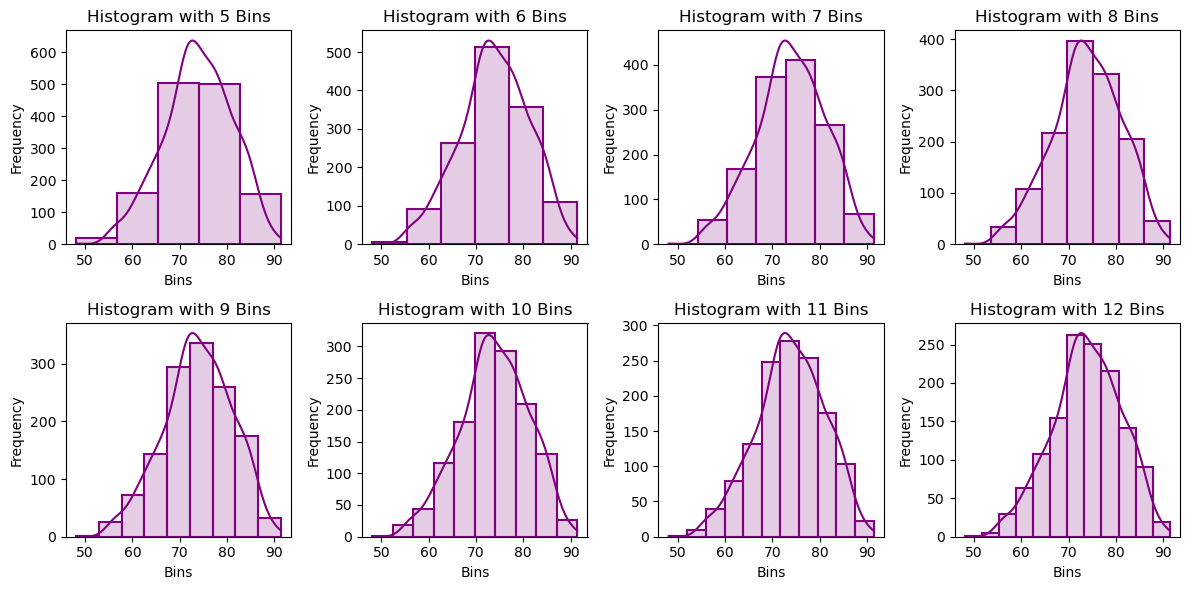

In [8]:
# To do this, I need to categorise age into bins

# Looking at how many bins to use for age that is appropriate for my planned methods

# Define the range of bin numbers to test what is appropriate (from 5 to 13)
bin_numbers = list(range(5, 13))

# Create subplots for each bin number
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot histograms with different bin numbers
for i, bins in enumerate(bin_numbers):
    sns.histplot(data=df, x='Age', bins=bins, ax=axes[i], color='purple', edgecolor='purple', linewidth=1.5, alpha=0.2, kde = True)
    axes[i].set_title(f'Histogram with {bins} Bins')
    axes[i].set_xlabel('Bins')
    axes[i].set_ylabel('Frequency')

# Adjust layout and display
plt.tight_layout()
plt.show()

Around 6-8 bins looks like a good amount to appropriately represent the data, 11+ may be getting into too many bins unnecessarily. However, I need to further investigate whether there will be enough people in each concatenated category with both age and diagnosis to conduct all my stratified splits.

Ideally, I need a minimum of 5 as I plan to split my data into 5 different groups: stage1_train, stage1_val, stage2_train, stage2_val, and test.

In [9]:
# Define the range of bin numbers to test
bin_numbers = list(range(3, 14))

# Iterate over different numbers of bins
for num_bins in bin_numbers:
    # Categorize the data into bins
    age_bins = pd.cut(df['Age'], bins=num_bins).tolist()
    
    # Create a new column by combining the bins and diagnosis
    combined_age_diagnosis_temp = [f"{age_bin}_{diagnosis}" for age_bin, diagnosis in zip(age_bins, df['Diagnosis'])]
    
    # Calculate the number of unique combinations
    unique_combinations = len(pd.Series(combined_age_diagnosis_temp).unique())
    
    # Calculate the minimum count of each combination
    min_count = pd.Series(combined_age_diagnosis_temp).value_counts().min()
    
    # Print the results
    print(f"Number of bins: {num_bins}")
    print(f"Number of unique combinations: {unique_combinations}")
    print(f"Minimum count of each combination: {min_count}\n")
    
    # Stop counting if the minimum count reaches 1 -- I need a minimum of 5 as I will have 5 splits
    if min_count == 1:
         break

Number of bins: 3
Number of unique combinations: 9
Minimum count of each combination: 6

Number of bins: 4
Number of unique combinations: 11
Minimum count of each combination: 8

Number of bins: 5
Number of unique combinations: 14
Minimum count of each combination: 4

Number of bins: 6
Number of unique combinations: 16
Minimum count of each combination: 6

Number of bins: 7
Number of unique combinations: 19
Minimum count of each combination: 1



Based on the above, we can see that **6 bins** would be the optimal number of age bins to use. This is beacuse:
- It meets the minimum requirements for 5 people within a single concatenated category (to allow a stratified split into 5 different groups)
- The number of bins is the highest it can be given this minimum of 5 (to allow the bins to be as representative of the data as possible)

In [10]:
# Create categories using age bins of 6

# Define the number of bins
num_bins = 6

# Create bin categories for age data
age_bins = pd.cut(df['Age'], bins=num_bins).tolist()

# Create a list by combining the bins and diagnosis
combined_age_diagnosis = [f"{age_bin}_{diagnosis}" for age_bin, diagnosis in zip(age_bins, df['Diagnosis'])]

## Splitting Data

In [11]:
# Initiate how data will be split into test and trainval
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15, random_state = 5)

# Split data into test and overall trainval
for i, (trainval_ind, test_ind) in enumerate(sss.split(df, combined_age_diagnosis)): # Stratify based on combined mri and age features  
    print(f"Fold {i}:")                             # Print each new fold (In this case there is only one)
    print(f"  Train+Val: index={trainval_ind}")     # Print the trainval indices
    print(f"  Test:  index={test_ind}")             # Print test indices

# I printed them to allow me to see how the data was split

# Create training and validation arrays
data_trainval = df.iloc[trainval_ind,:]                                     # Entire trainval set
features_trainval = data_trainval.iloc[:, 4:]                               # Featire select for mri features
agediag_trainval = pd.Series(combined_age_diagnosis).iloc[trainval_ind]     # Use this split for agediag as will need to use again in the next split

age_trainval = data_trainval['Age']                                         # Extract age (y1_trainval)
diag_trainval = data_trainval['Diagnosis']                                  # Extract diagnosis (y2_trainval)

# Create testing arrays
data_test = df.iloc[test_ind,:]                                             # Entire test set
features_test = data_test.iloc[:,4:]                                        # Feature select for mri
age_test = data_test['Age']                                                 # This will be y test

Fold 0:
  Train+Val: index=[355 557 373 ... 405 514 465]
  Test:  index=[1096  358 1129  218  804  991 1169  697  720 1003  478 1029 1021 1088
  287  196  888  688  193  854 1076   38  206  446 1136 1183 1205 1335
  880  987  832 1111  413  233 1055   18  142  721 1196  257  661  568
  856 1043 1086  769 1200  427   96  351  628  372 1152  267  342 1102
 1103  125  835 1126  156  269  451  833 1284   77  742   51  130  876
  998  751 1313 1278  483  371  797  622  951   56  839  484  582  559
  491  884 1298  386  654 1195 1121 1305  645  554 1323  251  782 1281
  874 1310    0  794  766  891 1062  984  209  523  445 1134  631  805
 1223  615  862 1071  905 1257  321  159  992  544 1110  345  264  502
  102  500   68 1140  210  185  564  320 1226  293  174  280  708  311
 1178  312 1258  941  953  517 1125 1336  214  932   16  146  101   42
   79 1048 1182  550  543  529  545  442  110  227  408  754  599  985
  539   49 1072  875  869 1321 1054  621  912 1122  877 1147   83  787
 1100

In [12]:
# Initiate how the trainval set will be split into two more trainvals
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 5)

# Split the trainval data into two equal trainval sets to be used for stage one and two
for i, (stage1_trainval_ind, stage2_trainval_ind) in enumerate(sss.split(features_trainval, agediag_trainval)): # Stratify based on combined mri and age features 
    print(f"Fold {i}:")                                                 # Print each new fold (In this case there is only one)
    print(f"  Stage 1 Train+Val: index={stage1_trainval_ind}")          # Print the trainval indices for stage one
    print(f"  Stage 2 Train+Val:  index={stage2_trainval_ind}")         # Print the trainval indices for stage two

# Create classification training and validation arrays
stage1_features_trainval = features_trainval.iloc[stage1_trainval_ind, :]       # Separate features (X1) for stage one
stage1_agediag_trainval = agediag_trainval.iloc[stage1_trainval_ind]            # Split agediag to be used for later splitting
stage1_diag_trainval = diag_trainval.iloc[stage1_trainval_ind]                  # Separate the diagnosis (y1) for stage one 

# Create regression training and validation arrays
stage2_features_trainval = features_trainval.iloc[stage2_trainval_ind,:]        # Separate features (unprocessed X2) for stage two
stage2_agediag_trainval = agediag_trainval.iloc[stage2_trainval_ind]            # Split agediag to be used for later splitting
stage2_age_trainval = age_trainval.iloc[stage2_trainval_ind]                    # Separate the age (y2) for stage two

Fold 0:
  Stage 1 Train+Val: index=[ 674  198   72  732  292  389 1052  159  328  559  939  871 1105   73
  787  556  943  831 1075   22  243  194  587 1062  377  543  623  746
  794    0   35  564  429  432  375  748  105  354  143  640  314  891
  964   62  981 1025  172  824  641 1035  202  877  723  577   26  464
  258  589  322  285 1120  125    1  249  111  147  195  173  819 1129
  795  575  476  350  826  851   20 1067  508  571 1116  735  880  282
  534  563  437   70  915 1112  847  902  600  393  893  593  870 1084
  638  489  864  118  341  801  171  719   52  379  395   47  581  145
 1103  458 1046 1091   28  453  727  255 1095  357  378  472 1083  769
  879  117  253 1008 1118   95 1024  874  246  781 1073  738  941  477
  654  233  695  985 1080  317  277  241  604  666 1030  767  424  266
  744  725 1071  435  949  141  205  441 1058  832  291  805 1089  887
  380   80  690  790  840  835  136  691  920  387  933 1023  165  570
  650  910 1036   29  355  637  397  447  

In [13]:
# Split trainval for stage one into training and validation data

stage1_no_models = 2    # Define number of classifier models I plan to use in stage one

# Initialise how data will be split into training and validation (80%/20%)
sss = StratifiedShuffleSplit(n_splits = stage1_no_models, test_size = 0.2, random_state = 5)

# Initialise empty dictionary to store train and val indices to be used in stage one
stage1_ind_dict = {}

for i, (stage1_train_ind, stage1_val_ind) in enumerate(sss.split(stage1_features_trainval, stage1_agediag_trainval)): # Stratify based on age and diagnosis 
    
    # Create a dictionary for each fold encompassing the indices for both train and validation
    fold_dict = {'train': stage1_train_ind, 'val': stage1_val_ind}
    
    # Store the nested dictionary in the stage1_ind_dict
    stage1_ind_dict[f'fold {i}'] = fold_dict

# Print the ind_dict to check the structure is as expected
print(stage1_ind_dict)

{'fold 0': {'train': array([223,  98, 429, 236, 410, 192, 370, 304,   0,  38, 345,  91, 463,
       557,  87, 313, 234, 516,  76, 331, 484, 184, 539,  37, 198, 353,
       558, 298, 263, 321, 193, 488, 340,  64,  97, 477, 221, 555, 215,
       121, 344, 454, 565, 100, 209, 220, 441, 324, 499, 105, 389, 478,
       458, 194,  13, 186,  72,  65, 191, 307, 342, 237, 385, 417,  69,
       414, 504, 250, 150, 501, 418, 480, 136, 139, 112,  86, 408, 434,
       476, 246, 498, 490, 325, 355, 368, 403, 428, 190, 281, 132, 294,
       135, 383, 276, 404, 120, 257, 226, 402, 288, 180, 262, 185, 472,
       420, 482, 523, 394,  71, 303, 129, 189, 283, 118, 143,  60, 159,
       326, 122, 216, 496,  63, 160, 319, 176, 278,  80, 553, 508,  20,
        25, 267, 249, 214, 479, 201, 538, 432,   6, 350, 491, 556, 466,
       495, 207, 500, 114,  51,  49, 453, 277, 444, 485, 260,  66, 224,
       494, 227, 401, 182, 503,  89,  34, 338,   3,  77, 164, 256, 181,
       103, 204, 235, 264, 465, 158, 284,  

In [14]:
# Separate training and validation for each fold using a loop
# Initialise empty lists to store the data for each fold
stage1_features_train = []
stage1_features_val = []
stage1_diag_train = []
stage1_diag_val = []

# Loop over the folds
for i in range(stage1_no_models):
    # Append the data for each fold to the corresponding list
    stage1_features_train.append(stage1_features_trainval.iloc[stage1_ind_dict[f'fold {i}']['train'], :])           # Training data mri features (X1_train)
    stage1_features_val.append(stage1_features_trainval.iloc[stage1_ind_dict[f'fold {i}']['val'], :])               # Validation data mri features (X1_val)
    stage1_diag_train.append(stage1_diag_trainval.iloc[stage1_ind_dict[f'fold {i}']['train']])                      # Training data diagnosis values (y1_train)
    stage1_diag_val.append(stage1_diag_trainval.iloc[stage1_ind_dict[f'fold {i}']['val']])                          # Validation data diagnosis values (y1_val)

Now that everything is split for stage one, lets look at the diagnosis split (y1)

In [15]:
# Count the number of diagnosis in each group to check they are split appropriately
for i in range(stage1_no_models):
    # Get the diagnosis labels for the training and validation data
    y_train = stage1_diag_train[i]
    y_val = stage1_diag_val[i]
    
    # Count the number of healthy controls and patients with AD in each data set
    n_train_cn = sum(y_train == 'CN')
    n_train_ad = sum(y_train == 'AD')
    n_train_mci = sum(y_train == 'MCI')

    n_val_cn = sum(y_val == 'CN')
    n_val_ad = sum(y_val == 'AD')
    n_val_mci = sum(y_val == 'MCI')
    
    # Print the results for each fold
    print(f"\n--- fold {i} ---")
    print(f"Training: {n_train_cn} controls, {n_train_ad} patients with AD, and {n_train_mci} patients with MCI")
    print(f"Validation: {n_val_cn} controls, {n_val_ad} patients with AD, and {n_val_mci} patients with MCI")



--- fold 0 ---
Training: 133 controls, 89 patients with AD, and 233 patients with MCI
Validation: 33 controls, 23 patients with AD, and 58 patients with MCI

--- fold 1 ---
Training: 133 controls, 89 patients with AD, and 233 patients with MCI
Validation: 33 controls, 23 patients with AD, and 58 patients with MCI


The splits in each fold are split accordingly

In [16]:
# Split trainval in stage two into training and validation

# Define how many regressor models I want to use in stage two
stage2_no_models = 2

# Initialise how trainval will be split into training and validation data (80%/20%)
sss = StratifiedShuffleSplit(n_splits = stage2_no_models, test_size = 0.2, random_state = 5)

# Initialise empty dictionary that will store the training and validation indices
stage2_ind_dict = {}

for i, (stage2_train_ind, stage2_val_ind) in enumerate(sss.split(stage2_features_trainval, stage2_agediag_trainval)): # Stratify based on age and diagnosis
    
    # Create a dictionary for each fold for traininga anad validation indices
    fold_dict = {'train': stage2_train_ind, 'val': stage2_val_ind}
    
    # Store the nested dictionary in the ind_dict
    stage2_ind_dict[f'fold {i}'] = fold_dict

# Print the ind_dict to check indices
print(stage2_ind_dict)

# Separate training and validation for each model using a loop
# Initialise empty lists to store the data for each fold
stage2_features_train = []
stage2_features_val = []
stage2_age_train = []
stage2_age_val = []

# Loop over the folds
for i in range(stage2_no_models):
    # Append the data for each fold to the corresponding list
    stage2_features_train.append(stage2_features_trainval.iloc[stage2_ind_dict[f'fold {i}']['train'], :])       # Training data mri features (unprocessed X2_train)
    stage2_features_val.append(stage2_features_trainval.iloc[stage2_ind_dict[f'fold {i}']['val'], :])           # Validation data mri features (unprocessed X2_val)
    stage2_age_train.append(stage2_age_trainval.iloc[stage2_ind_dict[f'fold {i}']['train']])                    # Training data age (y2_train)
    stage2_age_val.append(stage2_age_trainval.iloc[stage2_ind_dict[f'fold {i}']['val']])                        # Validation data age (y2_val)

{'fold 0': {'train': array([207, 192, 465, 254, 420, 497, 369, 523, 326,  44, 419, 475, 468,
       145, 266, 320, 425, 539, 103, 340, 181,  98, 272,  38, 212, 378,
       291, 108, 276, 462, 176, 171, 218, 117, 450, 480, 530, 526, 300,
        21, 302, 379, 263, 292, 332, 308, 277, 371, 495, 390, 554, 494,
       381, 213, 365, 197,  89, 446, 416, 327, 129, 307, 249, 414, 157,
       436, 183, 159, 283, 521, 360, 456, 124,  94,  65, 126, 406, 471,
         8, 289, 165, 243, 426, 496, 354,  74, 380, 210, 288, 167,  60,
        88, 396, 424, 341,  30, 273,  39, 410,  25, 189, 284, 413, 476,
       549, 125,  55,  59, 372, 313, 106, 404, 519, 367, 191,  80, 196,
       339,  79, 498, 508,  95, 185, 205, 543, 348, 435, 559, 368,  17,
       296, 325, 270, 232, 434, 217, 385, 469,  27, 278, 454, 464, 166,
       504, 248, 374,  70,  86,  37, 474, 287, 127, 485, 274,  77, 244,
       507, 299, 440,  56,  97, 148,  16, 271,   0, 137, 162, 323, 466,
       154, 216, 107, 359, 388, 246, 303,  

Now that everything is split for stage two, lets look at the splits distribution of age (y2) to double check everything is ok

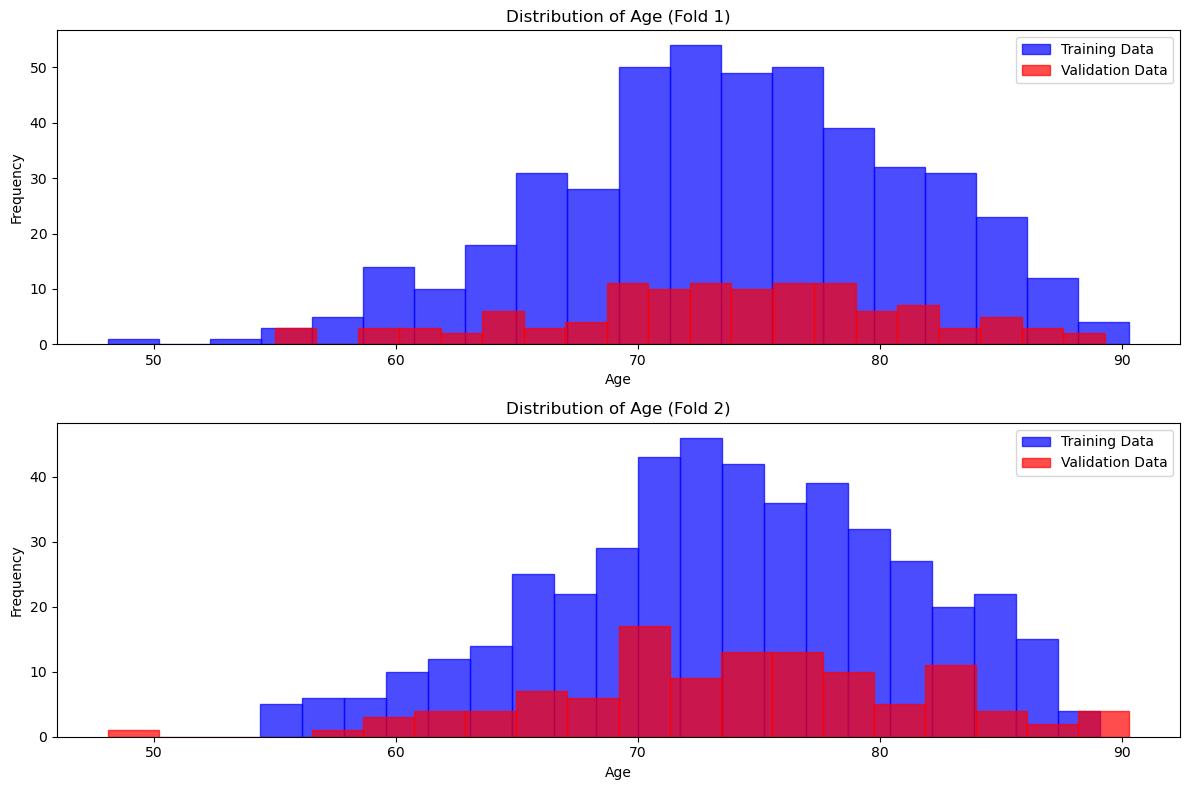

Train Age Stats
 count    455.000000
mean      73.749670
std        7.248113
min       54.400000
25%       69.400000
50%       73.700000
75%       79.150000
max       89.100000
Name: Age, dtype: float64 
Val Age Stats
 count    114.000000
mean      74.035965
std        7.810512
min       48.100000
25%       69.525000
50%       73.850000
75%       79.100000
max       90.300000
Name: Age, dtype: float64


In [21]:
# Create subplots
fig, axs = plt.subplots(stage2_no_models, figsize=(12, 8))

# For each fold in stage 2
for i in range(stage2_no_models):
    # Get the diagnosis labels for the training and validation data
    y_train = stage2_age_train[i]
    y_val = stage2_age_val[i]

    # Compute summary statistics for each group
    summary_stats_train = y_train.describe()
    summary_stats_val = y_val.describe()

    # Plot histograms for training and validation data
    axs[i].hist(y_train, bins=20, alpha=0.7, label='Training Data', color='blue', edgecolor='blue')
    axs[i].hist(y_val, bins=20, alpha=0.7, label='Validation Data', color='red', edgecolor='red')

    # Add labels, titles, and legends
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Distribution of Age (Fold {i+1})')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()  # Display plot

# Print the means and distributions
print('Train Age Stats\n', summary_stats_train, '\nVal Age Stats\n', summary_stats_val)

The histograms above indicate that there is a rough similarity of age distribution from training and validation. Although the distributions could be more alike, unfortuantely I chose the best number of age bins that it possible and cannot change to optimise it. Although it may be worth keeping in mind for future evaluation. 

# Stage One Modelling

Go through all the folds, apply different models and parameter tuning using a simple grid search

In [23]:
# Define classifiers with parameters I want to keep and not change
classifiers = [RandomForestClassifier(random_state = 3), SVC(kernel = 'poly', probability = True, random_state = 3)]

# Store the names for printing purposes
classifier_names = ['Random Forest Classifier', 'Support Vector Classifier']

# Dict to store all results that I will need for analysis and comparisons from cross validation
stage1_results = {   'optimised_classifiers': [],           # Optimised classifier model
                     'optimised_params': [],                # Optimised params found from hyperparameter tuning
                     'pipelines': [],                       # Final pipeline for each classifier
                     'true_values': [],                     # All true y values - for analysis
                     'predicted_values': []}                # All predicted y values - for analysis


# Set parameters I want to check which does best
stage1_param_grid = [{  'selector__alpha': [0.05, 0.035, 0.025, 0.015],     # alpha how many features where p value < alpha
                        'classifier__n_estimators': [135, 150, 165],
                        'classifier__max_depth': [8, 10, 12, 14],
                        'classifier__min_samples_split': [2, 3, 4, 5]},

                     {  'selector__alpha': [0.05, 0.04, 0.035, 0.025],
                        'classifier__C': [0.05, 0.1, 0.2, 0.5], 
                        'classifier__gamma': [1, 0.015, 0.02, 0.025]}]

# For each fold, use the training (X_train) and val (X_val) mri features (X1) and the training (y_train) and val (y_val) diagnosis (y1)
for fold_idx, (X_train, X_val, y_train, y_val) in enumerate(zip(stage1_features_train, stage1_features_val, stage1_diag_train, stage1_diag_val)):
    
    # Define pipeline items
    scaler = StandardScaler()                   # Create a standard scaler 
    selector = selector = SelectFpr(f_classif)  # Feature selection using fclass if
    classifier = classifiers[fold_idx]          # Focussed classifier for this fold

    param_grid = stage1_param_grid[fold_idx]    # Focussed param grid for this fold
    
    # Create pipeline for grid search
    paramtune_pipeline = Pipeline([
        ('scaler', scaler),
        ('selector', selector),
        ('classifier', classifier)
    ])

    # Print current progress
    print(f'\n--- {classifier_names[fold_idx]} ---')
    print('Hyperparameter tuning in progress...', end = '', flush = True) # Loop progress update

    # Nested Cross Validation for parameter tuning
    search = GridSearchCV(estimator = paramtune_pipeline, param_grid = param_grid)
    search.fit(X_train, y_train)

    print('\rHyperparameter tuning complete', end = '         ' ) # Print progress update

    # Define the best model with optimised parameters found from grid search
    best_model = search.best_estimator_

    stage1_results['optimised_classifiers'].append(best_model)           # Assign to dict for later use
    stage1_results['optimised_params'].append(search.best_params_)           # Assign best params for later use

    print('\nTraining and validation in progress...', end = '', flush = True)   # Progress update

    # Make and fit the best model with optimised params
    pipe = make_pipeline(best_model)            # Making pipeline        
    pipe.fit(X_train, y_train)                  # Train the pipeline

    y_val_pred = pipe.predict(X_val)            # Predict the diagnosis labels

    stage1_results['pipelines'].append(pipe)                    # Append with trained pipeline  
    stage1_results['true_values'].append(y_val)                 # Append for true diagnosis labels
    stage1_results['predicted_values'].append(y_val_pred)       # Append for predicted diagnosis labels

    print('\rTraining and validation complete', end = '         ' )     # Print progress update


--- Random Forest Classifier ---
Hyperparameter tuning in progress...

Hyperparameter tuning complete         
Training and validation complete         
--- Support Vector Classifier ---
Hyperparameter tuning complete         
Training and validation complete         

## Classifier Model Analysis

Analyse the cross validation predicted results to evaluate which model is the best

In [28]:
# Initialise dictionary to store scores (will turn into df later)
classifier_scores = {   'f1': [],
                        'accuracy': []}

# Initialise empty lists to store confusion matrices and selected features for each classifier
confusion_matrices = []
selected_features = []

# Run through each classifier and obtain f1 scores, accuracy scores, confusion matrices and selected features
for classifier_pipeline in range(stage1_no_models):
    true_values = stage1_results['true_values'][classifier_pipeline]              # Extract true values for current fold
    predicted_values = stage1_results['predicted_values'][classifier_pipeline]    # Extract the predicted values for current fold
    classes = stage1_results['pipelines'][classifier_pipeline].classes_           # Extract the pipeline classes used on fold

    ## Scores ##

    # Calculate scores
    f1 = f1_score(true_values, predicted_values, average='weighted')  # Calculate f1 score, which calculates metrics for each weighted label and average them
    accuracy = accuracy_score(true_values, predicted_values)          # Calculate accuracy score, which provides a % of correct predictions made

    # Append dict lists with scores
    classifier_scores['f1'].append(f1)                    
    classifier_scores['accuracy'].append(accuracy)  

    ## Confusion Matrix ##      

    # Create confusion matrix for each pipeline
    cm = confusion_matrix(true_values, predicted_values)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Append list with confusion matrices for each fold
    confusion_matrices.append(disp_cm)

    ## Selected Features ##

     # Access the 'SelectFpr' transformer
    select_fpr_transformer = stage1_results['pipelines'][classifier_pipeline].named_steps['pipeline'].named_steps['selector']

    # Get the mask of selected features from the SelectFpr transformer
    used_features_mask = select_fpr_transformer.get_support()

    # Extract the selected features using the mask
    used_features = stage1_features_train[classifier_pipeline].columns[used_features_mask]

    # Used feature pvalues
    used_feature_pvalues = select_fpr_transformer.pvalues_[used_features_mask]

    # Append list with selected features and their pvalues
    ind_feat = np.argsort(used_feature_pvalues)[:5]
    selected_features.append(used_features[ind_feat])
    
# Create dataframe with all scores and their classifier models
classifier_scores_df = pd.DataFrame(classifier_scores, index = classifier_names)

Having a look at the selected features that were used in the pipeline. This can be used to show whether our models found features that are consistent with existing literature

In [29]:
# Print all selected features
for classifier_pipeline in range(stage1_no_models):
    print(f'{classifier_names[classifier_pipeline]} pipeline selected features:')
    print(selected_features[classifier_pipeline])

Random Forest Classifier pipeline selected features:
Index(['BothHippocampus', 'LeftHippocampus', 'BothEntA', 'BothInfLatVent',
       'RightHippocampus'],
      dtype='object')
Support Vector Classifier pipeline selected features:
Index(['BothInfLatVent', 'LeftInfLatVent', 'BothEntA', 'BothAmygdala',
       'RightInfLatVent'],
      dtype='object')


We can see that the most significant features are hippocampus and ventricular plus amygdala. Hippocampus and ventricles are found as most important features in previous literature, so we are on the right track...

In [30]:
# Print scores dataframe
classifier_scores_df

,f1,accuracy
Random Forest Classifier,0.497722,0.535088
Support Vector Classifier,0.363907,0.438596


We can see that the RFC performed best with both accuracy and f1. Overall, we will only take into account f1 when it comes to looking at the best model, as this takes into account not only whether labels were correct or not, but also the confusion matrix. So it is better prepresentable on model performance.

The accuracy shows that RFC was just above 0.5, so it is lesser likely to have results due to chance.

Now plotting the confusion matrices...

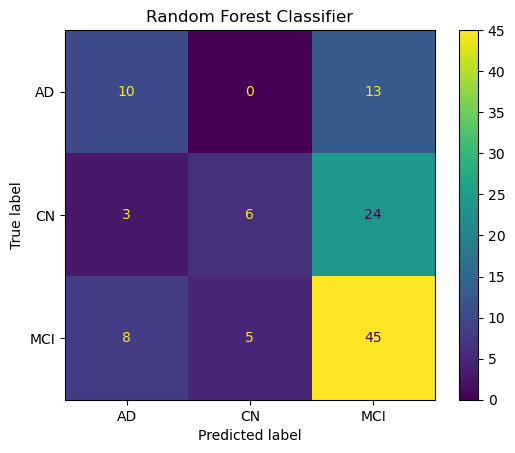

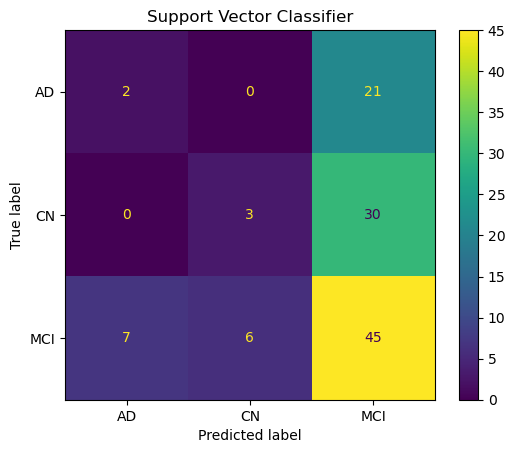

In [31]:
# Plot confusion matrices
for i in range(stage1_no_models):
    confusion_matrices[i].plot()
    plt.title(classifier_names[i])

We can see that both f1 and accuracy scores are higher for Random Forest Classifier. 

For the confusion matrix, , we expect to see that the diagonal from top left to bottom right are lighter colours and the rest of the squares should be as dark as possible. The confusion matrix also confirms that the RFC is the better model as the diagonal has higher numbers and the rest of the matrix is lower in numbers compared to the SVC.

Let's store the best classifier pipeline to use for stage two...

In [33]:
# Finding the best classifier of all:
best_classifier_ind = classifier_scores['f1'].index(max(classifier_scores['f1'])) # Get the index of the best classifier based on score
best_classifier = stage1_results['optimised_classifiers'][best_classifier_ind]                # Get the best classifier using index

# Print the best classifier pipeline with the optimal parameters
print(f"The best classifier is: {best_classifier}\n",
        f"The optimal parameters are: {stage1_results['optimised_params'][best_classifier_ind]}")

The best classifier is: Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', SelectFpr(alpha=0.025)),
                ('classifier',
                 RandomForestClassifier(max_depth=14, min_samples_split=4,
                                        n_estimators=150, random_state=3))])
 The optimal parameters are: {'classifier__max_depth': 14, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 150, 'selector__alpha': 0.025}


I am choosing to use the predicted probabilities for each label instead of taking the direct label, as it allows the regressor to take into account that these are predictions of diagnosis and may not be definitively accurate

### Create function for stage one

This is to make it easier to refer to and change if needed

In [34]:
from sklearn.feature_selection import SelectFpr

def apply_stageone(X_train, y_train, X_test, classifier_pipe):

    """
    Perform stage one modelling by training with X_train and y_train. Predictions are then made on X_test. 
    These predictions for diagnosis probabilities are then applied to the original X_test.
    This allows the X_test to be used ready for stage two.

    Parameters:
    - X1_train: Training data features for stage one.
    - y1_train: Training data labels for stage one.
    - X_test: Test data features.

    Returns:
    - stage2_Xtrain: Dataset for stage two modelling.
    """

    # Create Stage 1 pipeline 
    stage1_pipeline = make_pipeline(classifier_pipe)
    stage1_pipeline.fit(X_train, y_train)
    diag_probability_pred = stage1_pipeline.predict_proba(X_test)

    # Convert diag_probability_pred and X_test to a dataframe and reset index to concat 
    diag_probability_pred_df = pd.DataFrame(diag_probability_pred, columns=stage1_pipeline.classes_)
    X_test_df = pd.DataFrame(X_test)

    # Reset the index of the dataframes
    diag_probability_pred_df.reset_index(drop=True, inplace=True)
    X_test_df.reset_index(drop=True, inplace=True)

    # Using the predicted diagnosis, create a new dataset to be used for stage 2 modelling
    stage2_Xtrain = pd.concat([X_test_df, diag_probability_pred_df], axis = 1)

    return stage2_Xtrain

## Stage Two Modelling

Regressor models predicting age using mri features and predicted diagnosis probabilities

In [35]:
# Define regressors
regressors = [RandomForestRegressor(random_state = 0), ElasticNet(random_state = 0)]

# Define regressor names for printing purposes
regressor_names = ['Random Forest Regressor', 'Elastic Net']

# Create parameter grid with all params I want to test for each model
stage2_param_grid = [{  'selector__alpha': [0.085, 0.095, 0.1, 0.12],  # values of alpha for fclassif selector where p_values < alpha
                        'regressor__n_estimators': [50, 100, 150],
                        'regressor__max_depth': [None, 10, 20],
                        'regressor__min_samples_split': [2, 5, 10]},

                     {  'selector__alpha': [0.085, 0.095, 0.1, 0.12],
                        'regressor__alpha': [0.1, 0.5, 1.0], 
                        'regressor__l1_ratio': [0.1, 0.5, 0.9]}]

# Create empty dict to store important results after parameter tuning each model
stage2_results = {   'training_features': [],               # Training Features - needed for pipeline analysis later on
                     'optimised_classifiers': [],           # Optimised classifier 
                     'optimised_params': [],                # Best params
                     'pipelines': [],                       # Trained pipelines - needed for pipeline analysis
                     'true_values': [],                     # True y values - for analysis
                     'predicted_values': []}                # Predicted y values - for analysis

# Define X1_train and y1_train
X1_train = stage1_features_trainval       # Take the all training X data (combined trainval) from stage one
y1_train = stage1_diag_trainval           # Take the all training y data (combined trainval) from stage one

# For loop to iterate through folds with different regressors to find the best regressor its optimal parameters
for fold_idx, (X_train, X_val, y2_train, y2_val) in enumerate(zip(stage2_features_train, stage2_features_val, stage2_age_train, stage2_age_val)):
    
    # Printing current progress
    print(f'\n--- {regressor_names[fold_idx]} ---')
    print('Stage one modelling in progress...', end = '', flush = True)

    # Apply stage one modelling to create data for stage two training
    X2_train = apply_stageone(X1_train, y1_train, X_train, best_classifier)
    X2_val = apply_stageone(X1_train, y1_train, X_val, best_classifier)

    # Append training features list
    stage2_results['training_features'].append(X2_train)

    print('\rStage one modelling complete', end = '         ')  # Print progress
    
    # Define scaler, selector and regressor in prep for creating pipeline for parameter tuning 
    scaler = StandardScaler()           # Use standard scaler
    selector = SelectFpr(f_classif)     # Feature selection using fclassif
    regressor = regressors[fold_idx]    # Current focussed regressor
    
    # Define current param_grid in prep for parameter tuning
    param_grid = stage2_param_grid[fold_idx]

    # Create pipeline to parameter tune
    search_pipe = Pipeline([
        ('scaler', scaler),
        ('selector', selector),
        ('regressor', regressor)
    ])

    # Printing progress 
    print('\nHyperparameter tuning in progress...', end = '', flush = True)
    
    # Nested Cross Validation for hyperparameter tuning
    search = GridSearchCV(estimator = search_pipe, param_grid = param_grid) # Conduct grid search
    search.fit(X2_train, y2_train)          # Fit grid search

    print('\rHyperparameter tuning complete', end = '         ')    # Printing progress
    
    best_model = search.best_estimator_     # Obtain best model found from parameter tuning

    stage2_results['optimised_classifiers'].append(best_model)           # Assign to dict for later use
    stage2_results['optimised_params'].append(search.best_params_)           # Assign best params for later use


    print('\nTraining and validation in progress...', end = '', flush = True)   # Printing progress

    # Create pipeline using the best model
    pipe = make_pipeline(best_model)
    pipe.fit(X2_train, y2_train)            # Train pipeline using training data
    y2_val_pred = pipe.predict(X2_val)       # Predict age for validation data using pipeline

    # Store the pipeline, true values and predicted values in dict
    stage2_results['pipelines'].append(pipe)
    stage2_results['true_values'].append(y2_val)
    stage2_results['predicted_values'].append(y2_val_pred)

    print('\rTraining and validation complete', end = '          ', flush = True)       # Print progress


--- Random Forest Regressor ---
Stage one modelling complete         
Hyperparameter tuning complete         
Training and validation complete          
--- Elastic Net ---
Stage one modelling complete         
Hyperparameter tuning in progress...

c:\Users\hanif\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+01, tolerance: 1.885e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\hanif\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.440e+00, tolerance: 1.957e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\hanif\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.891e+00, toleranc

Hyperparameter tuning complete         
Training and validation complete          

## Regressor Model Analysis

Find the % error to be able to compare errors across each model - as the data used to calculate errors are not eaxctly the same

In [41]:
# Initialise dictionary to store scores (will turn into df later)
regressor_percentage_errors = []
mean_percentage_error = []

# Initialise empty lists to store confusion matrices and selected features for each classifier
selected_features_regressor = []

for regressor_pipeline in range(stage2_no_models):
    true_values = stage2_results['true_values'][regressor_pipeline]              # Extract true values for current fold
    predicted_values = stage2_results['predicted_values'][regressor_pipeline]    # Extract the predicted values for current fold

    ## Percentage Errors ##

    # Calculate absolute percentage errors
    p_errors = np.abs((predicted_values-true_values) / true_values) * 100       # List of absolute percentage errors

    # Store percentage error and the mean percentage error in lists for each regressor
    regressor_percentage_errors.append(p_errors)
    mean_percentage_error.append(np.mean(p_errors))

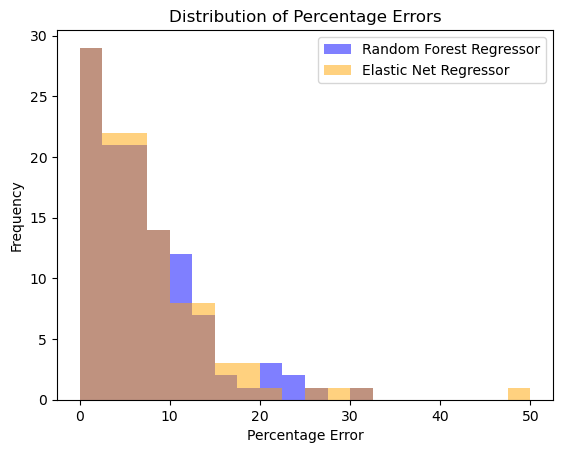

count    114.000000
mean       7.111352
std        6.148025
min        0.043103
25%        2.476979
50%        5.926149
75%        9.900260
max       30.440000
Name: Age, dtype: float64
count    114.000000
mean       7.272696
std        7.167078
min        0.038955
25%        2.424736
50%        5.719644
75%        9.753825
max       48.322131
Name: Age, dtype: float64


In [42]:
# Plot the % error for each group to compare the distributions

# Define bin edges to keep the bars same width
bin_edges = np.arange(0, 52.5, 2.5)

# Plot histograms overlaying for both models
plt.hist(regressor_percentage_errors[0], color='blue', alpha=0.5, label='Random Forest Regressor', bins = bin_edges)
plt.hist(regressor_percentage_errors[1], color='orange', alpha=0.5, label='Elastic Net Regressor', bins = bin_edges)

# Add labels
plt.xlabel('Percentage Error')                  # x label
plt.ylabel('Frequency')                         # y label
plt.title('Distribution of Percentage Errors')  # Title
plt.legend()                                    # Colour code the bars to each model
plt.show()                                      # Display plot

# Print the mean and distributions for each model
print(regressor_percentage_errors[0].describe())    
print(regressor_percentage_errors[1].describe())


Most errors are centered around 0% which is good. RFC has a lower error rate by a small marginal amount

In [43]:
# Finding the best regressor of all:
# We can compare % error as it is relative
best_regressor_ind = mean_percentage_error.index(min(mean_percentage_error))
best_regressor = stage2_results['optimised_classifiers'][best_regressor_ind]

print(f"The best regressor is: {best_regressor}\n",
        f"The optimal parameters are: {stage2_results['optimised_params'][best_regressor_ind]}")

The best regressor is: Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', SelectFpr(alpha=0.1)),
                ('regressor',
                 RandomForestRegressor(max_depth=20, n_estimators=150,
                                       random_state=0))])
 The optimal parameters are: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150, 'selector__alpha': 0.1}


## Final Pipeline Test

Apply the previously trained pipelines to the test data and see how well it performs overall

In [44]:
# Apply stage one to get the diagnosis predictions for the test
# Stage two pipeline will be applied to this to predict the data
X2_test = apply_stageone(X1_train, y1_train, features_test, best_classifier)

# Apply stage one to get the diagnosis predictions for stage two trainval set
# This set will be used to train for stage two
# Random seeds were generated, so the training should be the same as before
X2_train = apply_stageone(X1_train, y1_train, stage2_features_trainval, best_classifier)
y2_train = stage2_age_trainval

# Train stage two regressor using whole stage two training set 
best_regressor.fit(X2_train, y2_train)

# Create predictions on test using the fitted pipeline
test_pred = best_regressor.predict(X2_test)

In [45]:
# Print the mean absolute percentage error
print(f'The mean absolute percentage: {round(mean_absolute_percentage_error(age_test, test_pred)*100, 2)}%', 
      
      # Root Mean Square Error - To look at how far off case model predictions deviate from true values
      f'\nRoot mean squared error: {round(np.sqrt(mean_squared_error(age_test, test_pred)), 2)}')

The mean absolute percentage: 6.81% 
Root mean squared error: 6.25


The % is not too high, but could be better overall. Root mean error is ok, but again could be better

End of Script